In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import glob
import cv2
import os
import tqdm
import matplotlib.pyplot as plt
import random
import time
from model.FCN_ResNet50 import FCNResNet50
from model.unet_model import Unet
import argparse
import torch.nn.functional as F

## Read Global Varible

In [2]:
train_path = os.path.join('./train')
test_path = os.path.join('./test')


## Read color of label
f = open('label_colors.txt')
cate = f.read().split('\n')[:-1]
cate_dist = {}
cate_list = []

for name in cate:
    color, cate = name.split('\t')[0], name.split('\t')[-1]
    color = color.split(' ')
    cate_dist[cate] = [int(i) for i in color]
    cate_list.append(cate)

## Transform data from np to torch
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

## Dataset

### Read Dataset

In [3]:
def make_dataset(path, val_split=0.1):
    """
    Input: path, Ratio to split Train and Validation data
    Output: [training img path, training label], [validation img path, validation label]
    """
    label_path = glob.glob(os.path.join(path, '*_C.png'))
    sample_list = []
    for labelfile in tqdm.tqdm(label_path):
        imfile = os.path.join(labelfile.split('_C.png')[0]+'.png')
        sample_list.append((imfile, labelfile))

    num_val_samples = int(len(sample_list) * val_split)
    np.random.shuffle(sample_list)
    if num_val_samples != 0:
        train_samples = sample_list[:-num_val_samples]
    else:
        train_samples = sample_list
    val_samples = sample_list[-num_val_samples:]
    
    return train_samples, val_samples

### Image and Label Augmentation

In [4]:
def aug_image(oimg, label, crop_flag):
    crop = lambda oimg, x0, y0, w, h: oimg[y0:y0+h, x0:x0+w]
    img = np.concatenate((oimg, label[:, :, np.newaxis]), axis=2)
    """
    angle: Rotation angle
    crop_flag: need to crop or not
    """
    
    key = random.randint(0,1)
    prob = random.random()
    if prob > 0.5:
        img = cv2.flip(img, 1)

    if key == 0:
        angle = random.randint(0,15)
    else:
        angle = random.randint(345,360)
    h, w = img.shape[:2]
    angle %= 360
    # get Affine transformation matrix
    M_rotation = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
    # get the rotation result.
    img[:,:,:-1] = cv2.warpAffine(img[:,:,:-1], M_rotation, (w, h), flags=cv2.INTER_NEAREST, borderValue=(255,255,255))
    img[:,:,-1] = cv2.warpAffine(img[:,:,-1], M_rotation, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
    img_rotated = img
    
    # If need to crop the black area.
    if crop_flag:
        angle_crop = angle % 180
        if angle > 90:
            angle_crop = 180 - angle_crop
        # transfrom the angle to radion 
        theta = angle_crop * np.pi / 180
        # get height-weight ratio
        hw_ratio = float(h) / float(w)
        # calculate the crop coefficient  
        tan_theta = np.tan(theta)
        numerator = np.cos(theta) + np.sin(theta) * np.tan(theta)

        r = hw_ratio if h > w else 1 / hw_ratio
        # get divisor
        denominator = r * tan_theta + 1
        # get the final coefficient
        crop_mult = numerator / denominator

        # get crop area
        w_crop = int(crop_mult * w)
        h_crop = int(crop_mult * h)
        x0 = int((w - w_crop) / 2)
        y0 = int((h - h_crop) / 2)
        
        img_rotated = crop(img_rotated, x0, y0, w_crop, h_crop)
    
    res_img = img_rotated[:, :, 0:-1]
    res_label = np.squeeze(img_rotated[:, :, -1])
        
    return res_img, res_label

### Check img and corresponded label

In [5]:
def check(loader):
    '''
        Input: Dataloader
    '''
    for idx, (data, label) in enumerate(loader):
        if idx == 3:
            break
        print(f"Feature batch shape: {data.size()}")
        print(f"Labels batch shape: {label.size()}")
        img = data[0].squeeze()
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)

        label = label[0]
        label = label.swapaxes(0, 1)
        label = label.swapaxes(1, 2)
        label = torch.argmax(label, dim=2)

        label_rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

        for idx, cate in enumerate(cate_list):
            label_rgb[label == idx, :] = cate_dist[cate] 


        fig = plt.figure(figsize=(10, 5))
        fig.add_subplot(1, 2, 1)        
        plt.axis('off')
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.axis('off')
        plt.imshow(label_rgb)

        plt.show()

### Construct CAM101TrainingData Dataset class

In [6]:
class CAM101TrainingData(Dataset):
    def __init__(self, samples, transform=None, label_transform=None):
        super(Dataset, self).__init__()
        self.sample = samples
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, index):
        imgpath, labelpath = self.sample[index]
        img = cv2.imread(imgpath)
        label = Image.open(labelpath)
        label = np.asarray(label)

        if self.transform is not None:
            img, label = aug_image(img, label, True)

        img = data_transforms(img)

        label = cv2.resize(label, (256, 256), interpolation=cv2.INTER_NEAREST)
        temp_label = np.zeros((32, label.shape[0], label.shape[1]), dtype=np.uint8)

        for i in range(32):
            temp_label[i, label==i] = 1

        return img, temp_label

## Self defined Loss Function

### class weight

In [7]:
def calculate_class_weights(train_samples, num_classes):
    """
    Input: training data, num_classes
    Output: class_weight
    """
    class_counts = np.zeros(num_classes)
    for _, label_path in train_samples:
        label = Image.open(label_path)
        label = np.asarray(label)
        for cls in range(num_classes):
            class_counts[cls] += (label == cls).sum()

    total_count = class_counts.sum()
    zero_data = (class_counts == 0).sum()   
    class_weights = total_count / ((num_classes-zero_data) * class_counts)
    class_weights[class_counts == 0] = 0

    return class_weights

### Dice Loss

In [8]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
 
    def forward(self, logits, targets):
        num = targets.size(0)
        smooth = 1
        probs = F.softmax(logits, dim=1)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
 
        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

## Model

### FCNResNet50

In [9]:
from torchvision import models
import torch.nn as nn
class FCNResNet50(nn.Module):
    def __init__(self, num_classes):
        super(FCNResNet50, self).__init__()
        base_model = models.resnet50(pretrained=True)
        layers = list(base_model.children())[:-2]
        self.base = nn.Sequential(*layers)
        self.head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, num_classes, kernel_size=32, stride=32, padding=0, output_padding=0, bias=False)
        )


    def forward(self, x):
        x = self.base(x)
        x = self.head(x)
        return x

### U-Net

In [10]:
import torch
from torch import nn
import torch.nn.functional as F 
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX-diffX // 2,
                        diffY // 2, diffY-diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, self.bilinear)
        self.up2 = Up(512, 256 // factor, self.bilinear)
        self.up3 = Up(256, 128 // factor, self.bilinear)
        self.up4 = Up(128, 64, self.bilinear)
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

## Evaluation Function

### Pixel Accuracy

In [11]:
def pixel_accuracy(pred, target, testing=False):
    if testing:
        pred = np.squeeze(pred, axis=0)
        target = np.squeeze(target, axis=0)

        pred = cv2.resize(pred, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_NEAREST)
        
    else:
        target = np.argmax(target, axis=1)
    
    TP = np.sum(pred == target)
    if testing:
        area = target.shape[0] * target.shape[1]
    else:
        area = target.shape[0] * target.shape[1] * target.shape[2]

    return float(TP/area)

### Calculate Intersection over Union(IoU)

In [12]:
def iou_metric(pred, target, num_classes, testing=False):
    """
        Input: Pred, Target, num_classes
        Output: IoU(batch_size, num_classes)
    """
    ious = []
    if testing:
        pred = np.squeeze(pred, axis=0)
        target = np.squeeze(target, axis=0)

        pred = cv2.resize(pred, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        target = np.argmax(target, axis=1)
        
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).sum()
        union = pred_inds.sum() + target_inds.sum() - intersection

        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(float(intersection) / float(union))

    return np.array(ious)

### Function to evaluate the model and compute IoU

In [13]:
def evaluate_model(model, criterion, dataloader, device, num_classes, is_deeplab=False):
    model.eval()
    iou_list = []
    acc_list = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

            outputs = model(inputs)
        
            if is_deeplab:
                outputs = outputs['out']     

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            ious = iou_metric(preds.cpu().numpy(), labels.cpu().numpy(), num_classes)
            pixel_acc = pixel_accuracy(preds.cpu().numpy(), labels.cpu().numpy())
            iou_list.append(ious)
            acc_list.append(pixel_acc)

    stacked_iou = np.vstack(iou_list)
    mean_iou = np.nanmean(stacked_iou, axis=0)
    mean_acc = np.mean(acc_list)
    return val_loss, mean_iou, mean_acc

## Training

### Function to train the model

In [14]:
def train_model(model, criterion, optimizer, dataloader, device, is_deeplab=False):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if is_deeplab:
            outputs = outputs['out']

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

### Training Process

In [15]:
def process(model_name,
            is_aug,
            loss,
            is_deeplab = False,
            batch_size=3,
            base_lr = 0.001,
            max_epoch = 100,
            num_classes = 32):
    
    best_loss = float('inf')

    ### Instantiate the datasets and dataloaders with the new transforms
    train_samples, val_samples = make_dataset(train_path)
    if is_aug is False:
        ### Baseline
        train_data = CAM101TrainingData(train_samples)
        val_data = CAM101TrainingData(val_samples)
        data = 'baseline'
    else:
        ### Aug
        train_data = CAM101TrainingData(train_samples, transform=data_transforms)
        val_data = CAM101TrainingData(val_samples)
        data = 'aug'

    train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
    
    # Create the model
    if model_name == 'FCN':
        model = FCNResNet50(num_classes=num_classes)
    elif model_name == 'Unet':
        model = Unet(n_channels=3, n_classes=num_classes, bilinear=True)
    elif model_name == 'deeplab':
        model = models.segmentation.deeplabv3_resnet50(num_classes=num_classes)
        is_deeplab = True
    else:
        print("Too creative!")
        exit()
    
    # Get the model parameters.
    total = sum([param.nelement() for param in model.parameters()])
    print("Number of parameter: %.2fM" % (total/1e6))


    # Move the model to the appropriate device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(model)

    # Define the loss function and optimizer
    if loss == 'CE':
        # cross entropy
        criterion = nn.CrossEntropyLoss()
    elif loss == "WCE":
        # # weighted cross entropy
        class_weights = calculate_class_weights(train_samples, num_classes)
        class_weights = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    elif loss == "Dice":
        # # Dice loss
        criterion = SoftDiceLoss().to(device) #real


    model_path = os.path.join('./checkpoints', model_name, data, loss)
    print(model_path, model_name, data, loss)

    optimizer = optim.Adam(model.parameters(), lr=base_lr)


    # Main training loop
    train_losses = []
    val_losses = []
    val_ious = []
    val_accs = []

    total_time = 0
    for epoch in range(0, max_epoch):
        start_time = time.time()
        train_loss = train_model(model, criterion, optimizer, train_dataloader, device, is_deeplab=is_deeplab)
        total_time += (time.time()-start_time)
        val_loss, mean_iou, mean_acc = evaluate_model(model, criterion, val_dataloader, device, num_classes, is_deeplab=is_deeplab)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_ious.append(mean_iou)
        val_accs.append(mean_acc)

        print(f"Epoch: {epoch+1}/{max_epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Mean IoU: {np.nanmean(mean_iou):.4f}, Validation Pixel Acc: {mean_acc:.4f}")

        # Save the model if the validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_path, f"model_best.pth"))
            print(f"save_best on epoch{epoch+1}")
        
        if (epoch+1) % max_epoch == 0:
            torch.save(model.state_dict(), os.path.join(model_path, f"model_{epoch+1}.pth"))

    print(f"Training complete, total spend time:{total_time} to training")

    # Plot the training and validation loss
    
    fig = plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(model_path, '1.png'))
    plt.show()
    

    # Plot the mean IoU for each class over time
    val_ious = np.vstack(val_ious)
    plt.figure()
    for cls in range(num_classes):
        plt.plot(val_ious[:, cls], label=f"Class {cls}")

    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.legend()
    plt.savefig(os.path.join(model_path, '2.png'))
    plt.show()


    # Plot the mean pixel_acc over time
    val_accs = np.vstack(val_accs)
    plt.figure()
    plt.plot(val_accs)

    plt.xlabel("Epoch")
    plt.ylabel("Pixel Acc")
    plt.legend()
    plt.savefig(os.path.join(model_path, '3.png'))
    plt.show()

### Main Training Function

100%|██████████| 90/90 [00:00<00:00, 2194693.95it/s]


Number of parameter: 41.33M
FCNResNet50(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

C:\Users\sovereign\AppData\Local\Temp\ipykernel_17344\4042937827.py:25: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(stacked_iou, axis=0)


Epoch: 1/10, Train Loss: 1.1816, Validation Loss: 7.0939, Validation Mean IoU: 0.2084, Validation Pixel Acc: 0.7886
save_best on epoch1
Epoch: 2/10, Train Loss: 0.4720, Validation Loss: 4.2152, Validation Mean IoU: 0.2835, Validation Pixel Acc: 0.8570
save_best on epoch2
Epoch: 3/10, Train Loss: 0.3758, Validation Loss: 3.5327, Validation Mean IoU: 0.3333, Validation Pixel Acc: 0.8781
save_best on epoch3
Epoch: 4/10, Train Loss: 0.3353, Validation Loss: 3.1631, Validation Mean IoU: 0.3461, Validation Pixel Acc: 0.8861
save_best on epoch4
Epoch: 5/10, Train Loss: 0.3109, Validation Loss: 2.9899, Validation Mean IoU: 0.3780, Validation Pixel Acc: 0.8907
save_best on epoch5
Epoch: 6/10, Train Loss: 0.2924, Validation Loss: 2.8657, Validation Mean IoU: 0.4035, Validation Pixel Acc: 0.8950
save_best on epoch6
Epoch: 7/10, Train Loss: 0.2685, Validation Loss: 2.8076, Validation Mean IoU: 0.4138, Validation Pixel Acc: 0.8944
save_best on epoch7
Epoch: 8/10, Train Loss: 0.2518, Validation Loss

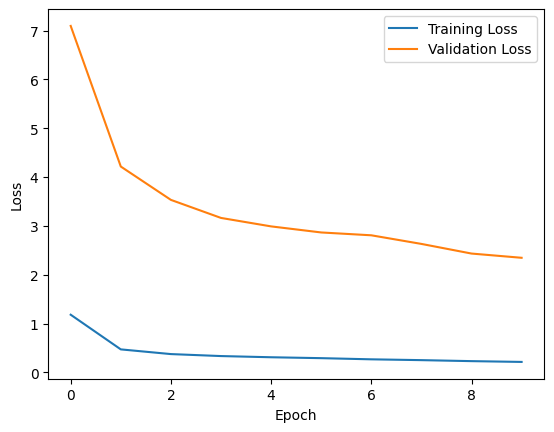

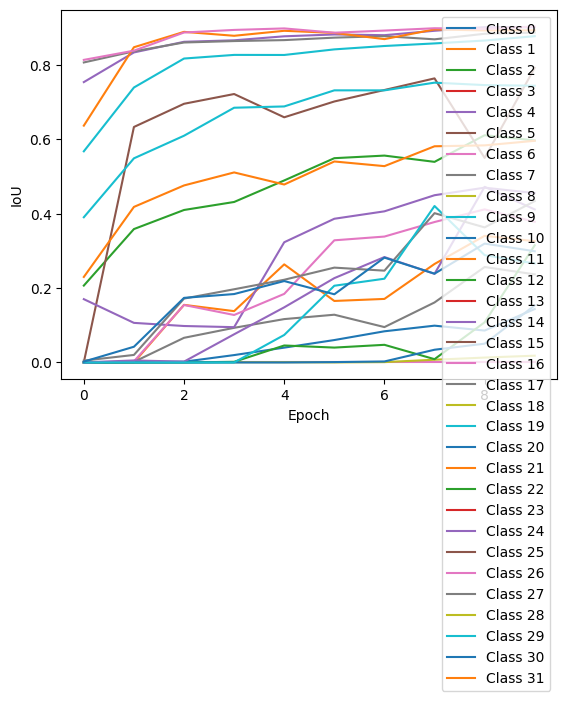

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


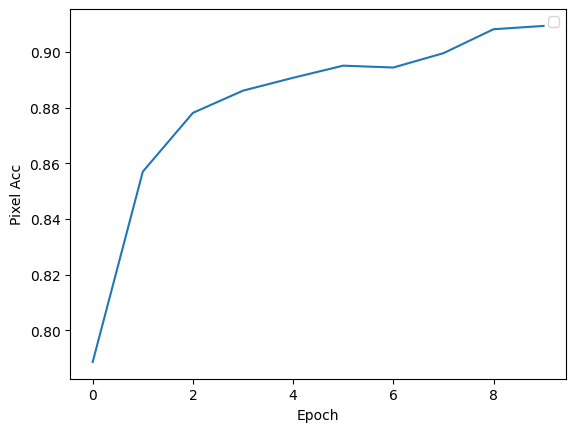

100%|██████████| 90/90 [00:00<00:00, 90307.98it/s]


Number of parameter: 41.33M
FCNResNet50(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

C:\Users\sovereign\AppData\Local\Temp\ipykernel_17344\1155275068.py:15: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_count / ((num_classes-zero_data) * class_counts)


./checkpoints\FCN\baseline\WCE FCN baseline WCE
Epoch: 1/10, Train Loss: 2.2697, Validation Loss: 17.0573, Validation Mean IoU: 0.1698, Validation Pixel Acc: 0.4703
save_best on epoch1
Epoch: 2/10, Train Loss: 1.2728, Validation Loss: 9.6921, Validation Mean IoU: 0.2781, Validation Pixel Acc: 0.6954
save_best on epoch2
Epoch: 3/10, Train Loss: 0.9729, Validation Loss: 8.7115, Validation Mean IoU: 0.3081, Validation Pixel Acc: 0.7326
save_best on epoch3
Epoch: 4/10, Train Loss: 0.8078, Validation Loss: 8.6389, Validation Mean IoU: 0.3078, Validation Pixel Acc: 0.6771
save_best on epoch4
Epoch: 5/10, Train Loss: 0.6807, Validation Loss: 8.1231, Validation Mean IoU: 0.3255, Validation Pixel Acc: 0.7318
save_best on epoch5
Epoch: 6/10, Train Loss: 0.5964, Validation Loss: 7.8121, Validation Mean IoU: 0.3614, Validation Pixel Acc: 0.7726
save_best on epoch6
Epoch: 7/10, Train Loss: 0.5501, Validation Loss: 7.5198, Validation Mean IoU: 0.3725, Validation Pixel Acc: 0.7919
save_best on epoch7

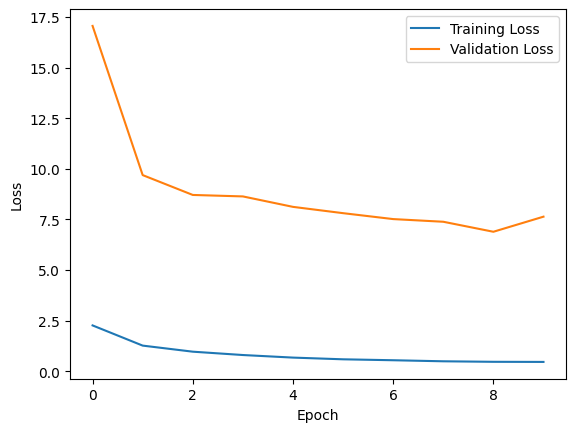

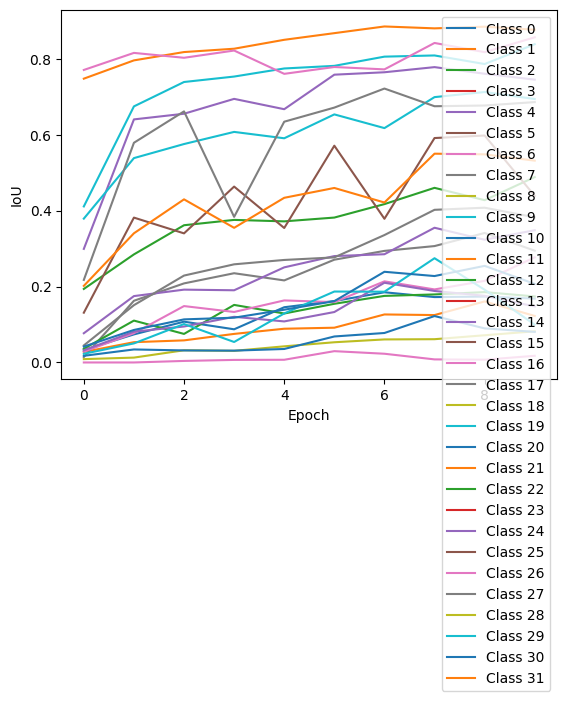

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


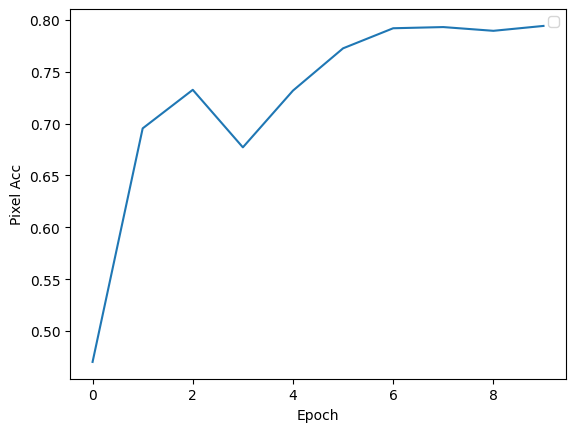

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 41.33M
FCNResNet50(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

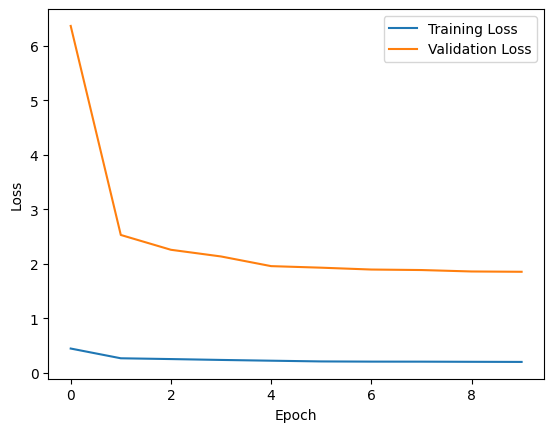

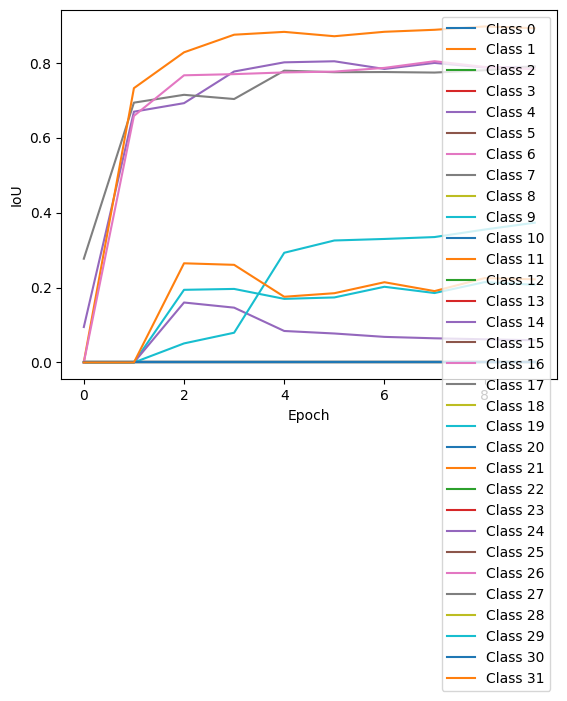

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


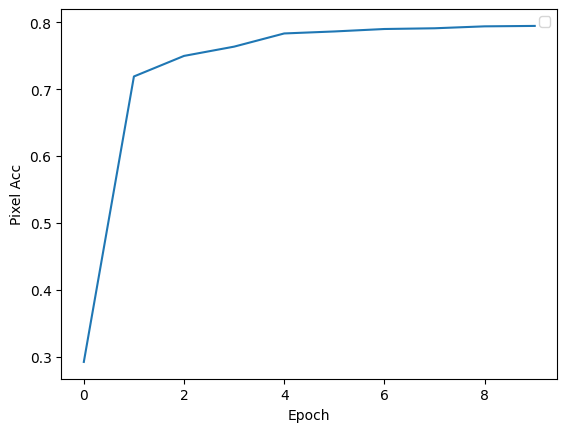

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 41.33M
FCNResNet50(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

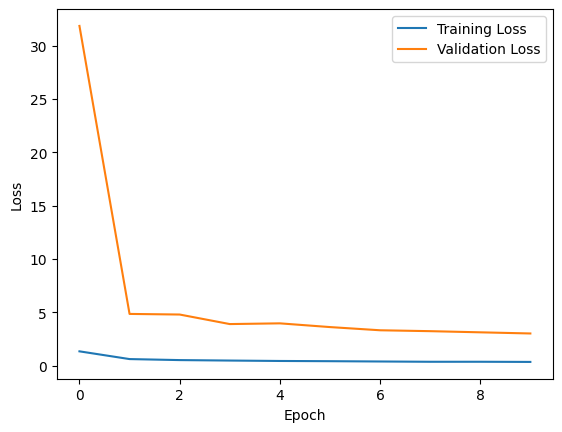

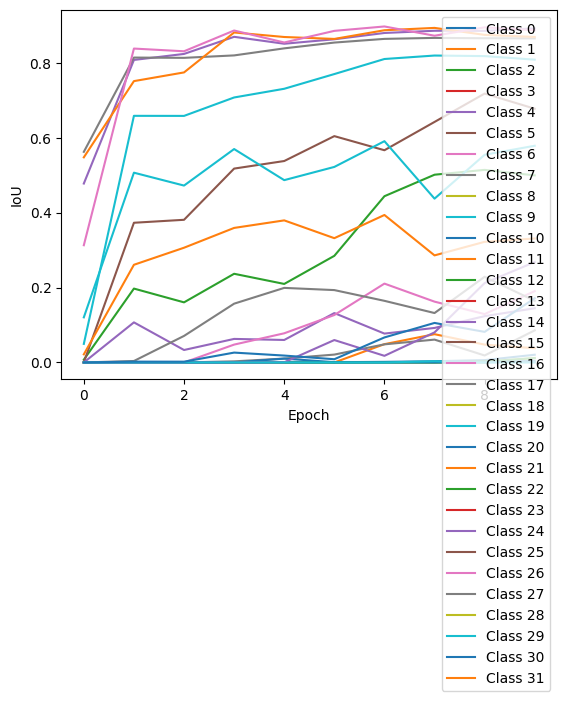

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


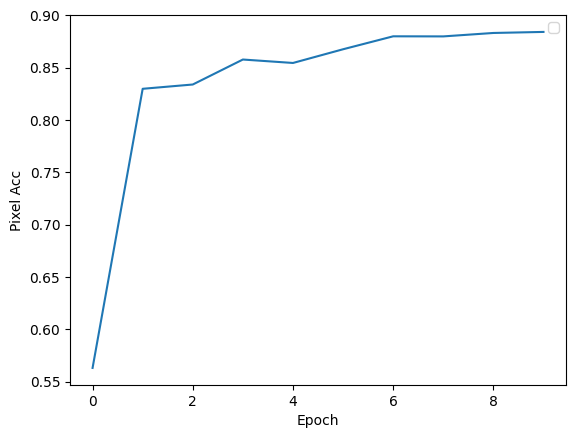

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 41.33M
FCNResNet50(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

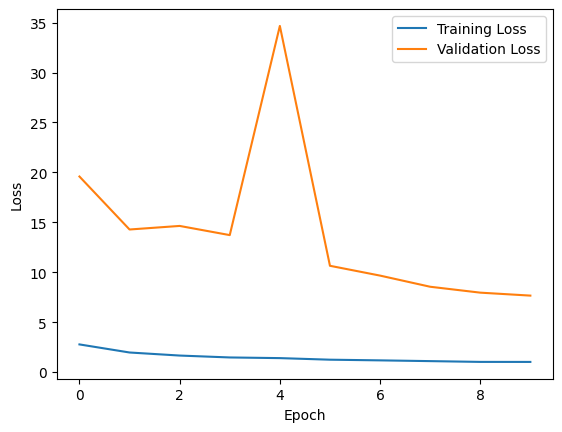

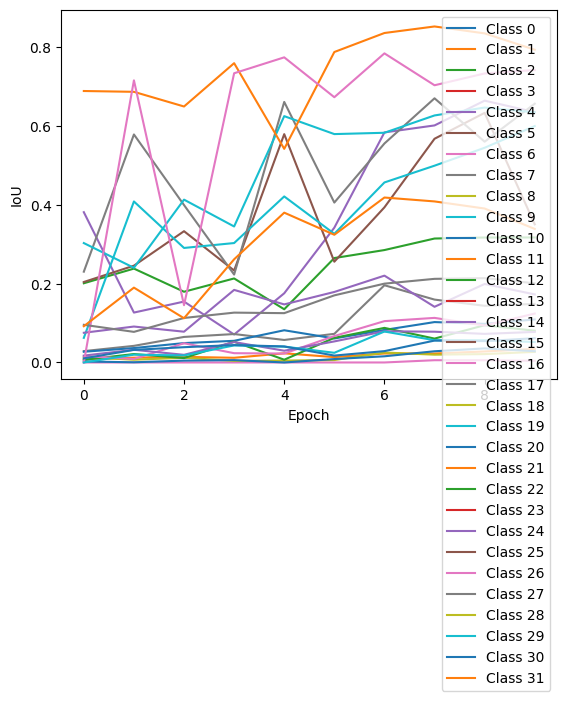

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


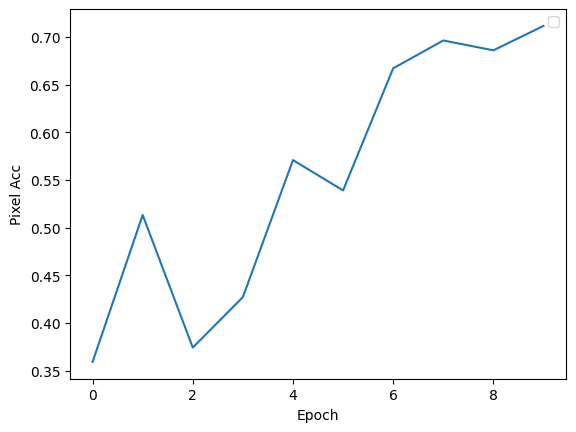

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 41.33M
FCNResNet50(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

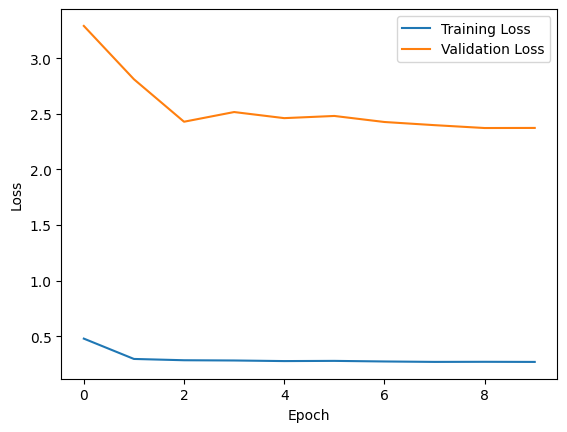

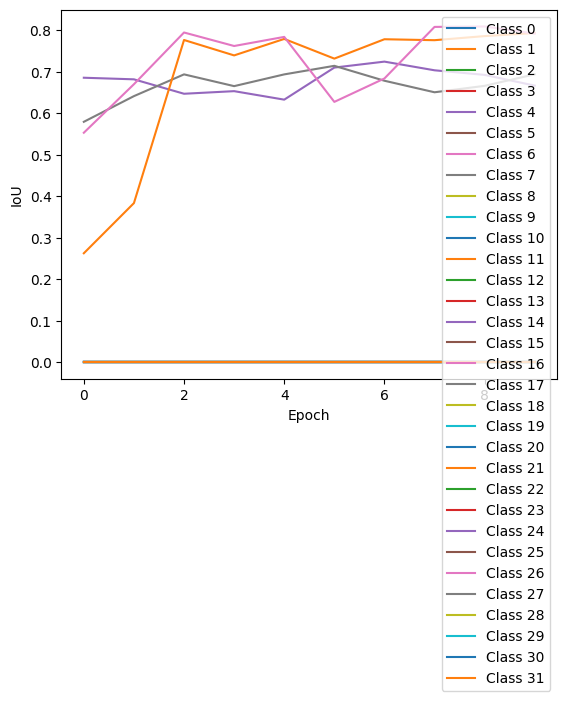

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


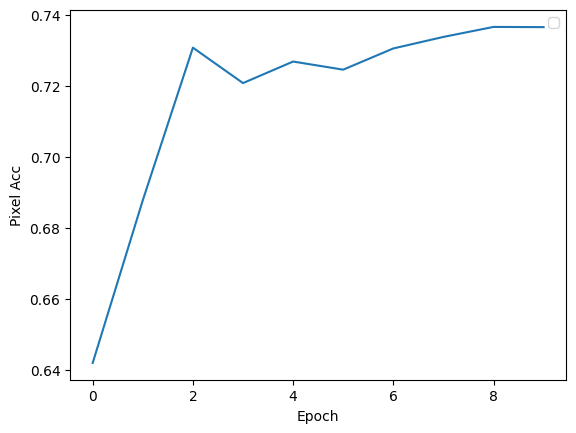

100%|██████████| 90/90 [00:00<00:00, 90329.59it/s]


Number of parameter: 17.26M
Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.

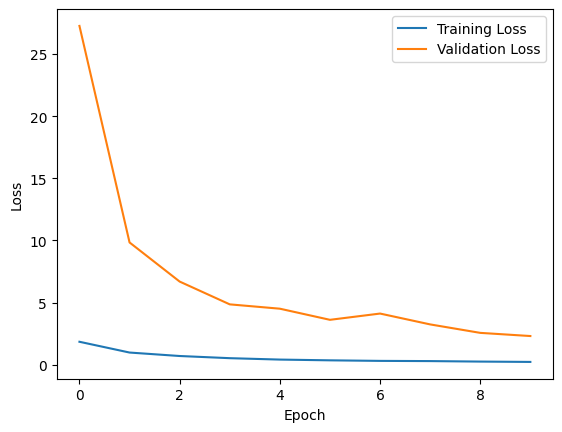

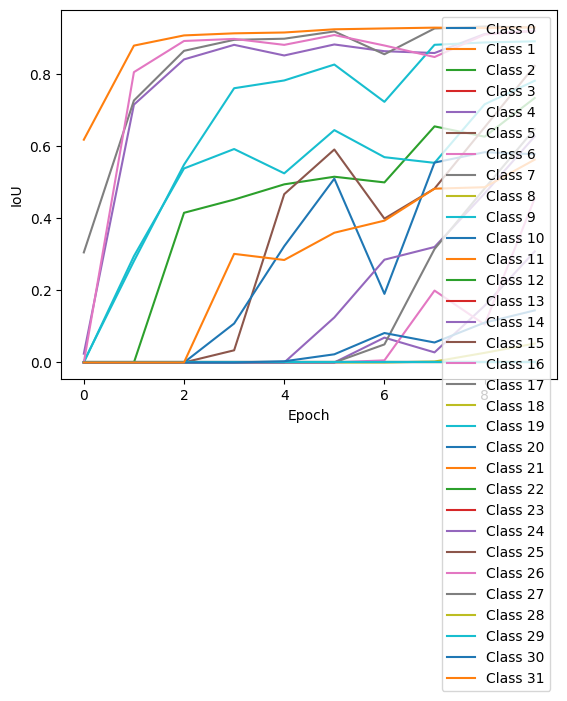

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


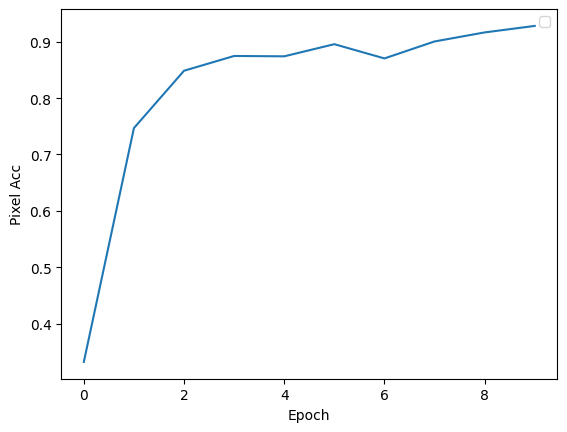

100%|██████████| 90/90 [00:00<00:00, 181135.97it/s]


Number of parameter: 17.26M
Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.

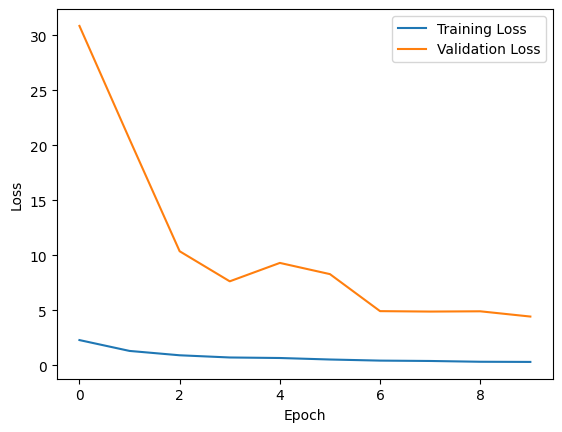

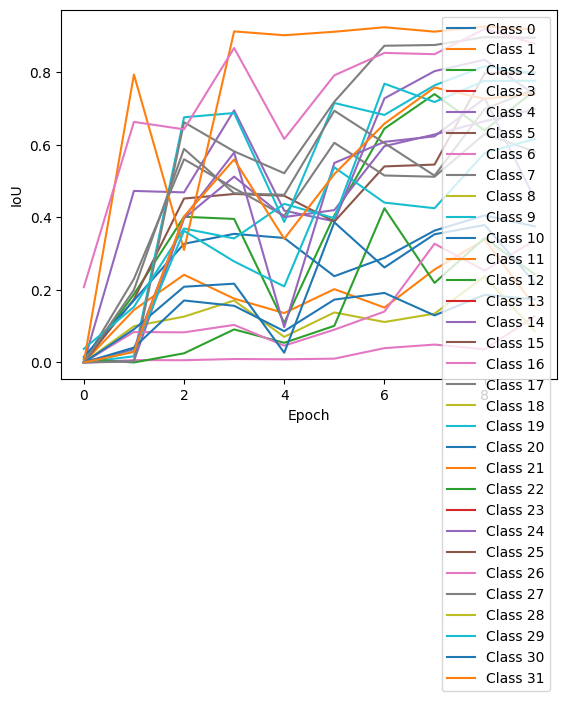

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


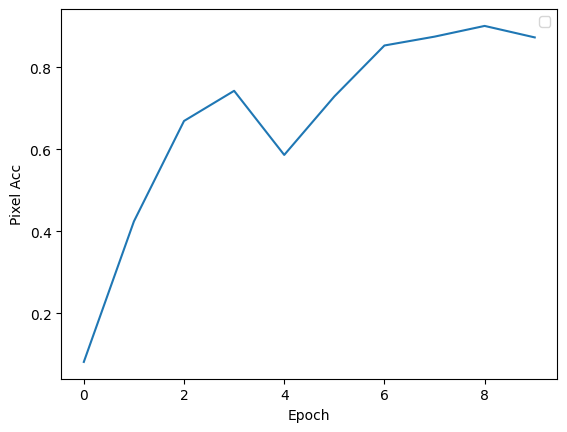

100%|██████████| 90/90 [00:00<00:00, 1306184.64it/s]


Number of parameter: 17.26M
Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.

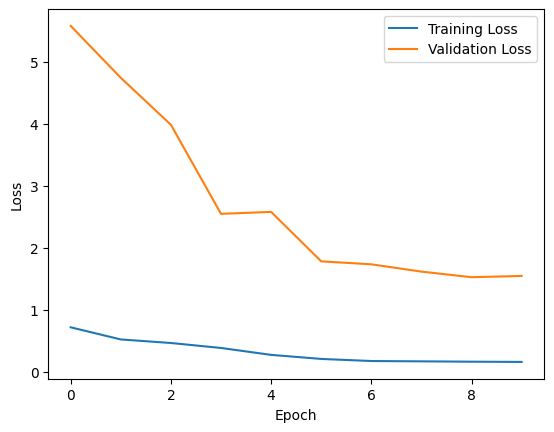

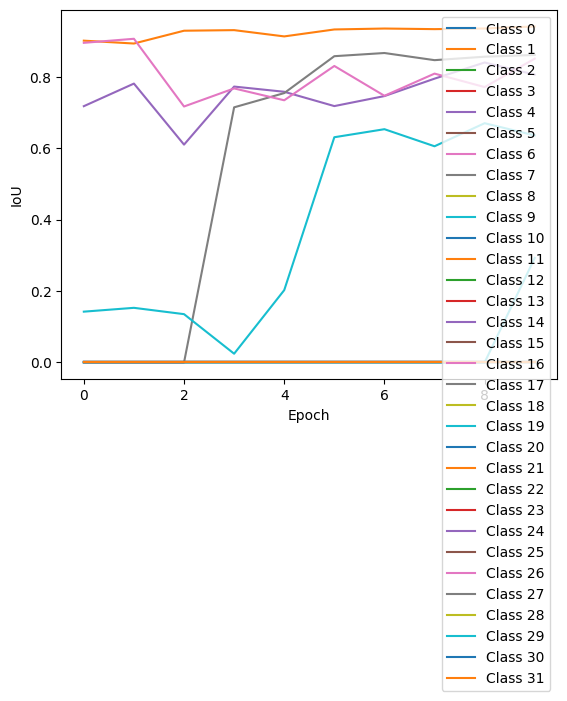

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


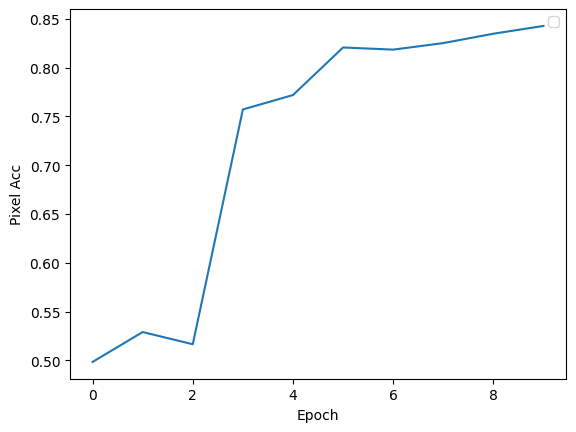

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 17.26M
Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.

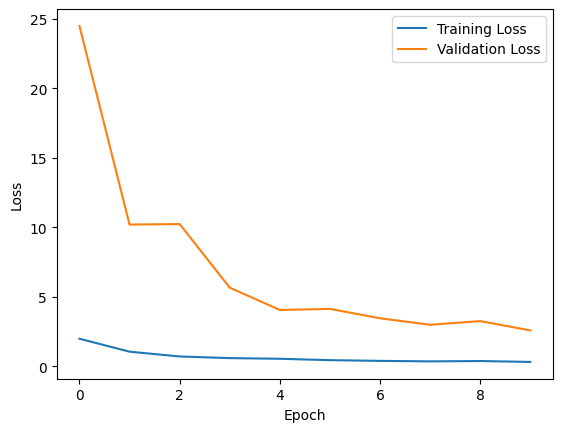

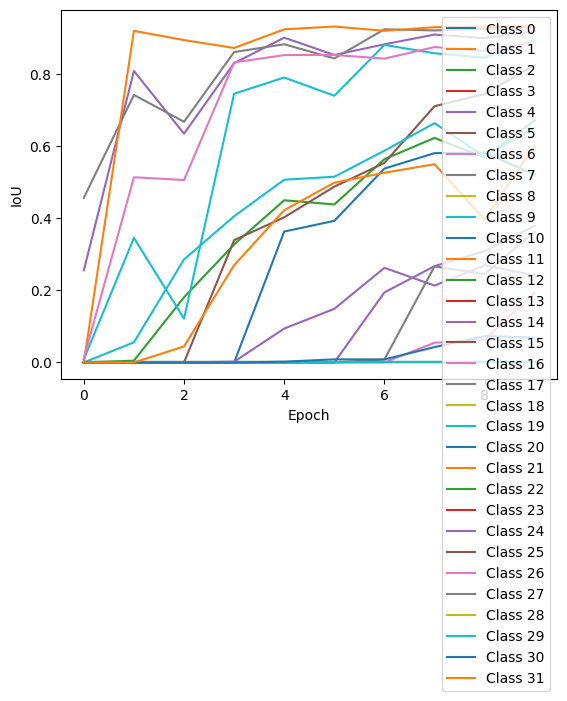

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


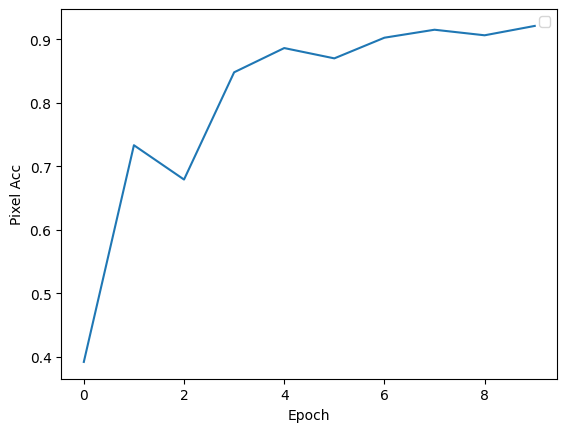

100%|██████████| 90/90 [00:00<00:00, 90307.98it/s]


Number of parameter: 17.26M
Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.

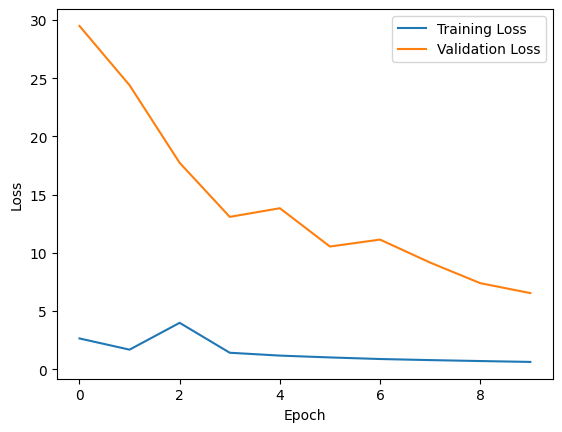

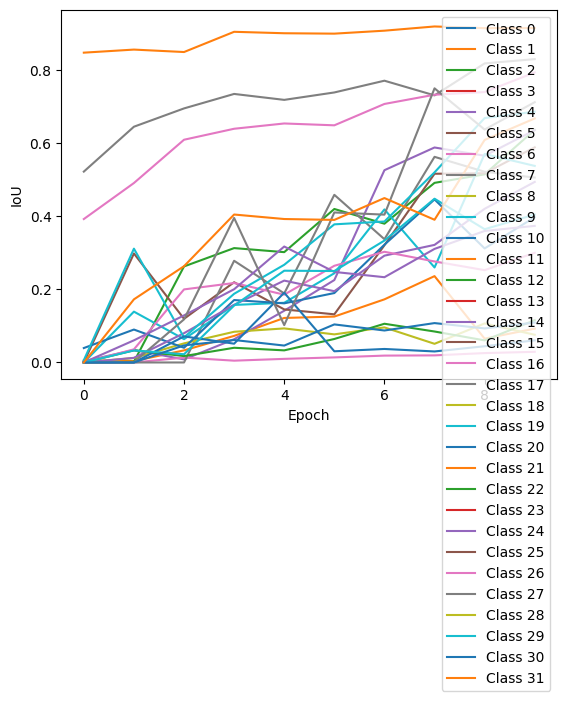

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


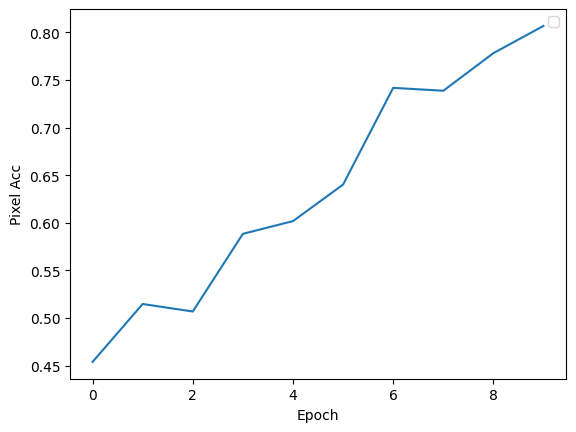

100%|██████████| 90/90 [00:00<00:00, 66623.25it/s]


Number of parameter: 17.26M
Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.

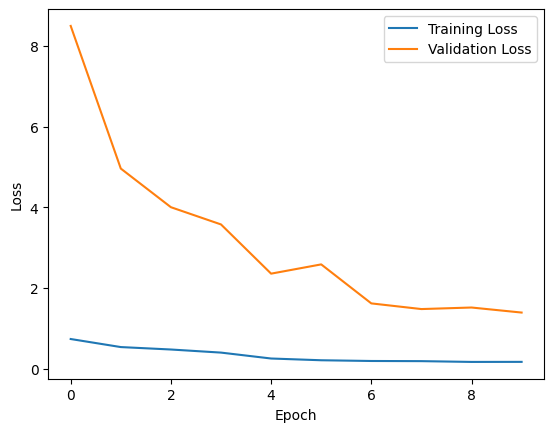

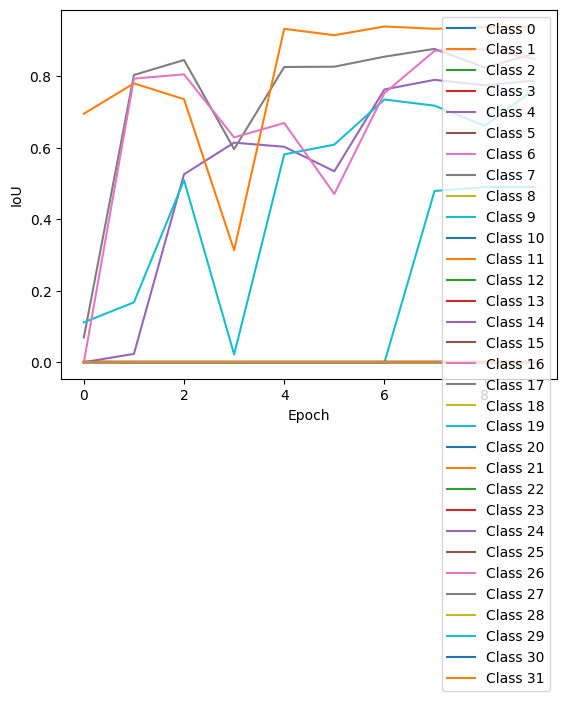

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


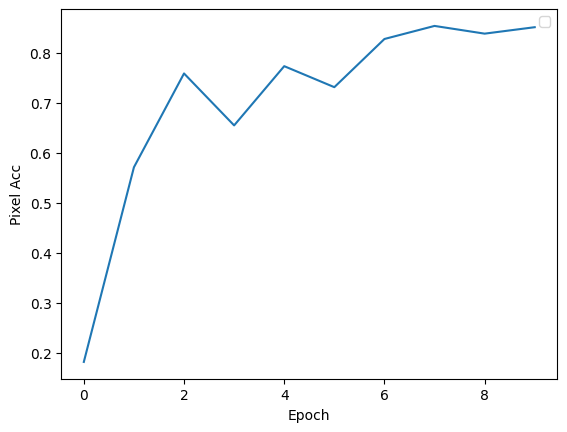

100%|██████████| 90/90 [00:00<00:00, 90329.59it/s]


Number of parameter: 39.64M
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

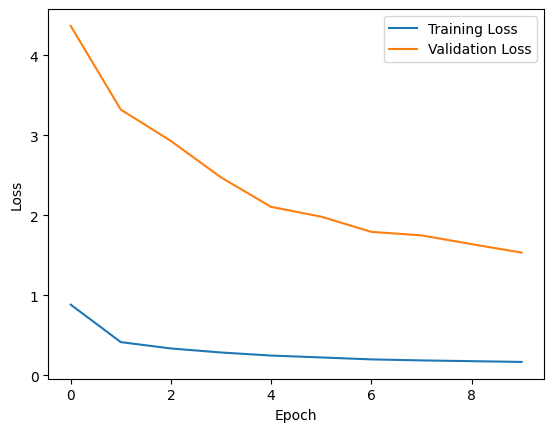

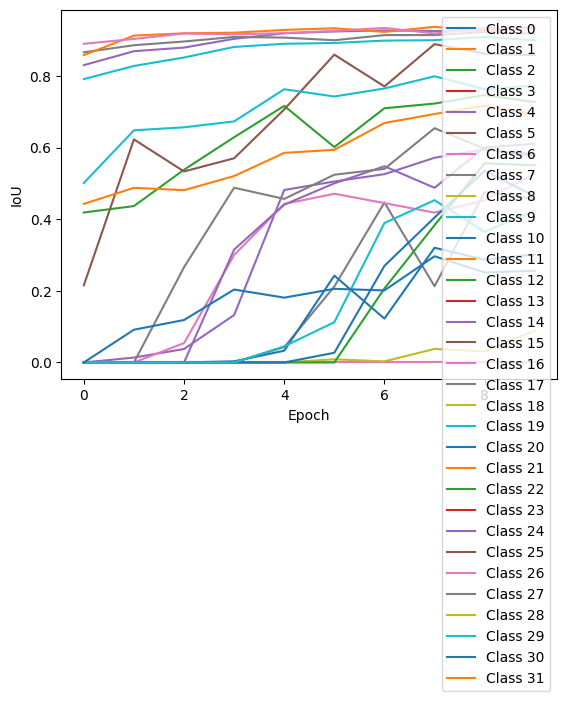

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


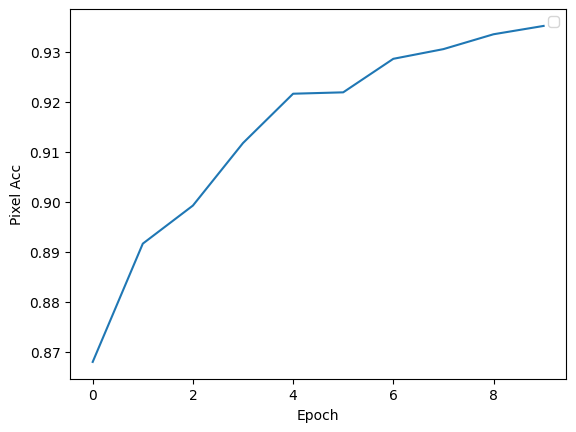

100%|██████████| 90/90 [00:00<00:00, 90286.38it/s]


Number of parameter: 39.64M
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

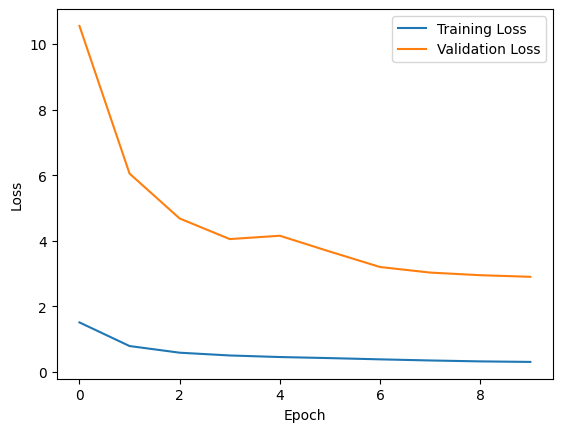

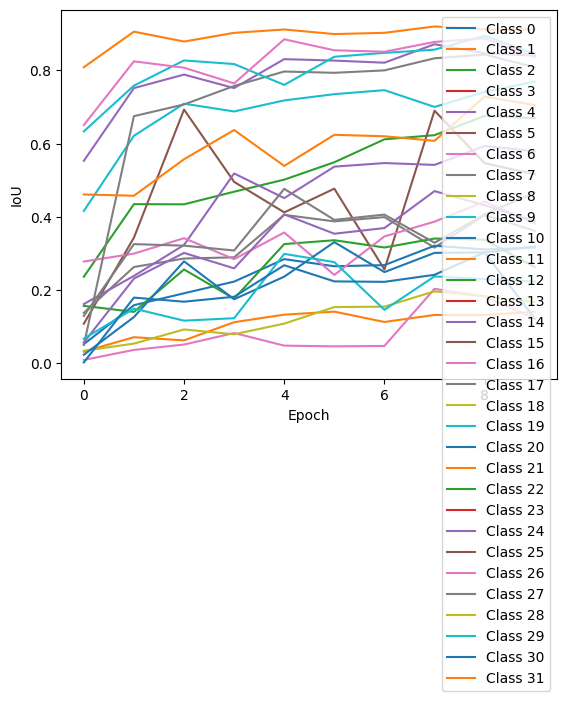

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


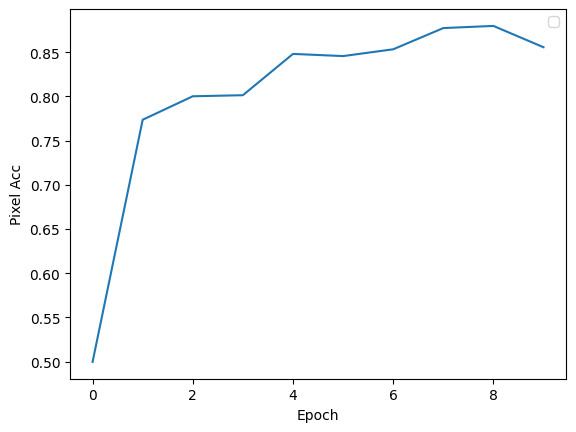

100%|██████████| 90/90 [00:00<00:00, 90027.99it/s]


Number of parameter: 39.64M
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

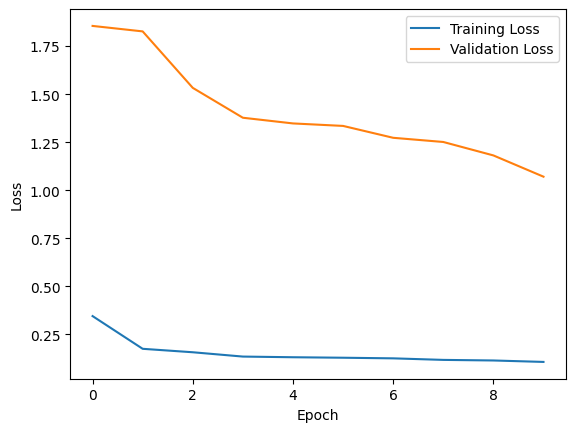

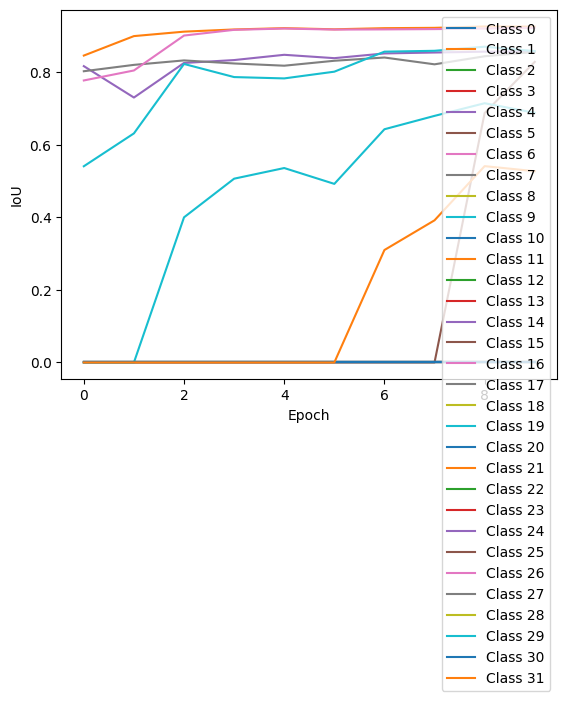

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


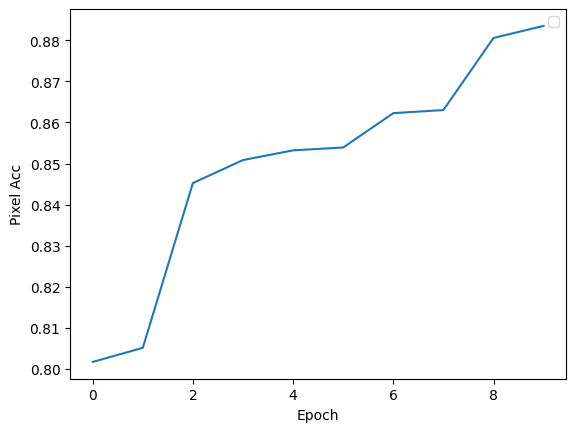

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 39.64M
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

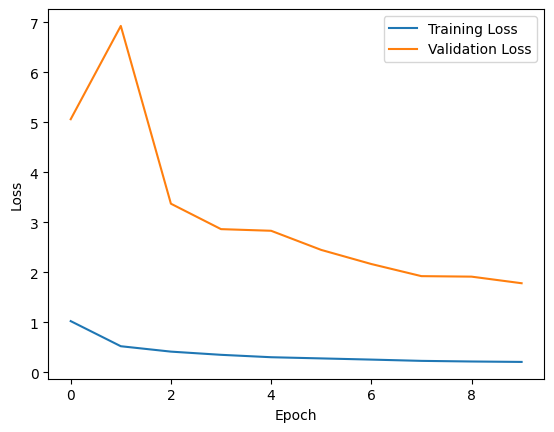

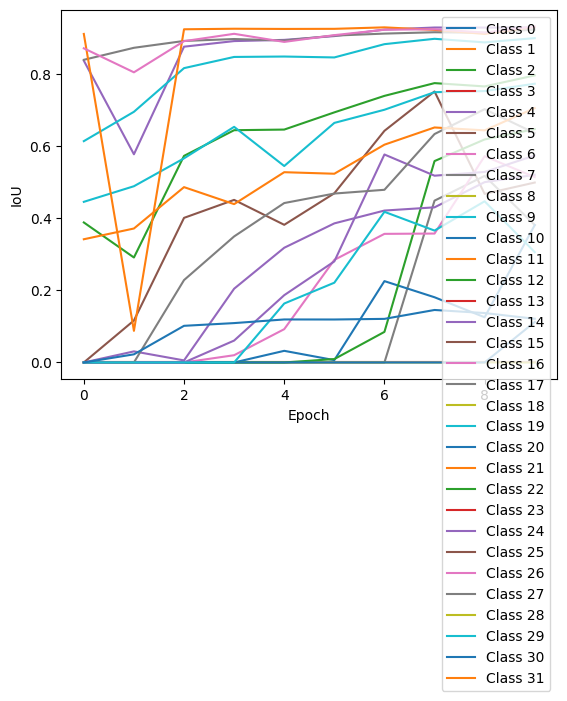

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


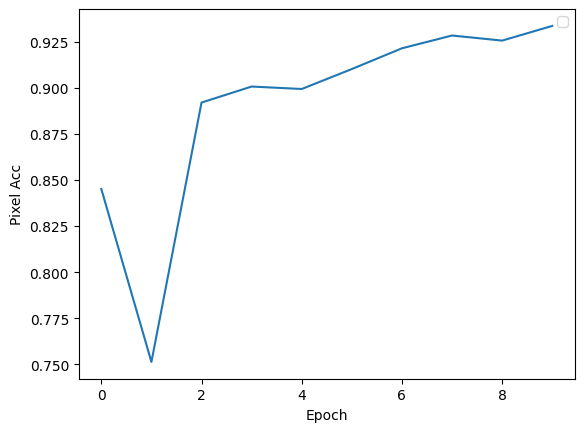

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 39.64M
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

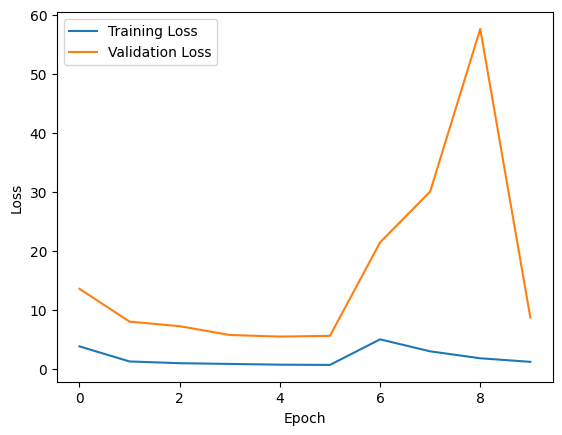

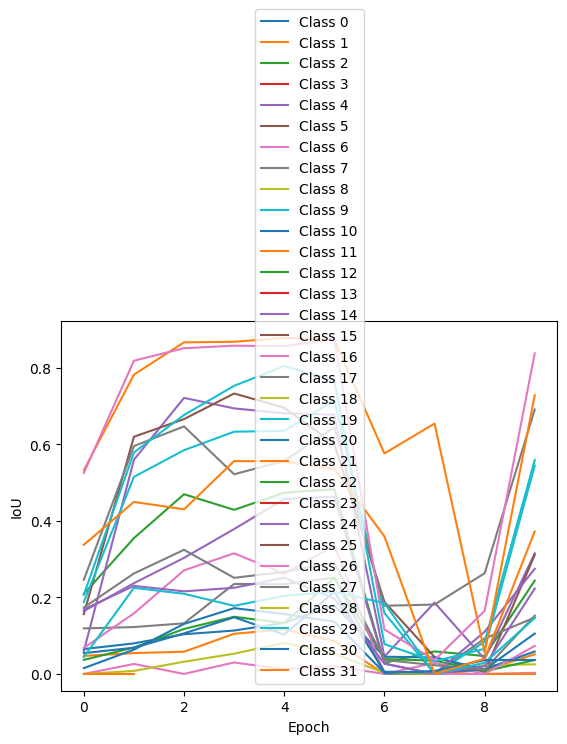

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


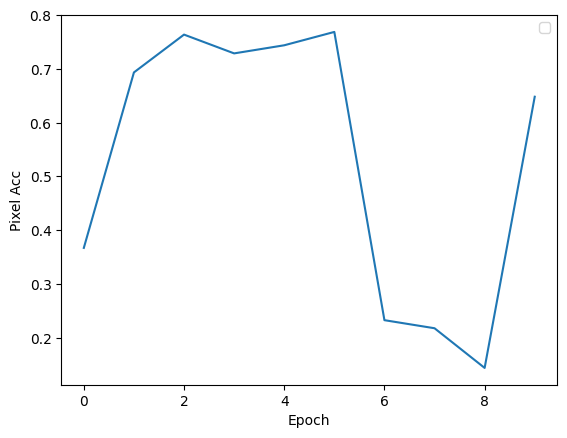

100%|██████████| 90/90 [00:00<?, ?it/s]


Number of parameter: 39.64M
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=Tr

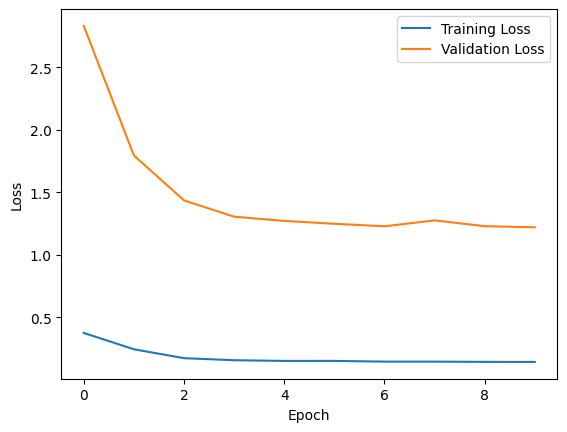

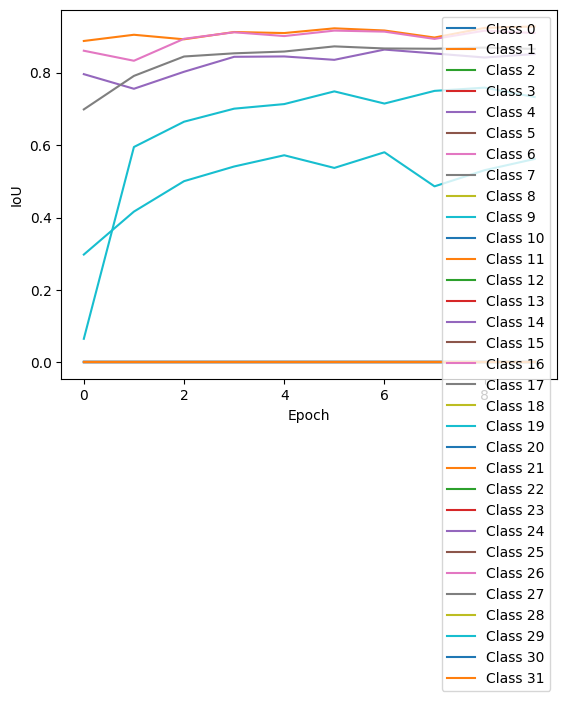

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


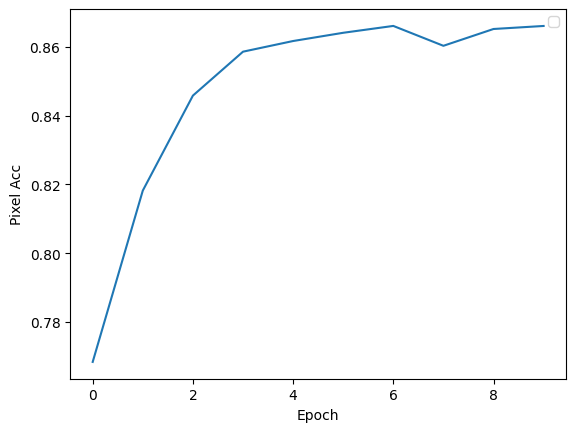

In [131]:
# Switch Model/ Augmentation/ Loss Function and Train
model = ['', 'FCN', 'Unet', 'deeplab']
is_aug = True
loss = ['', 'CE', 'WCE', 'Dice']

for m in range(1, 4):
    for a in range(2):
        for lo in range(1, 4):
            process(model[m], bool(a), loss[lo], max_epoch=10)

## Testing 

### Construct CAM101TestingData Dataset class

In [18]:
class CAM101TestingData(Dataset):
    def __init__(self, samples, transform=None, label_transform=None):
        super(Dataset, self).__init__()
        self.sample = samples
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, index):
        imgpath, labelpath = self.sample[index]
        img = cv2.imread(imgpath)
        label = Image.open(labelpath)
        label = np.asarray(label)
        
        img = data_transforms(img)

        return img, label


### Visualization

In [19]:
def labeltorgb(label):
    labelrgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for idx, cate in enumerate(cate_list):
        labelrgb[label == idx, :] = cate_dist[cate]

    return labelrgb

### Save Testing Image

In [31]:
def saveimg(model_name, ab, loss, idx, inputs, pred, target):
    inputs = np.squeeze(inputs, axis=0)
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.swapaxes(inputs, 1, 2)

    pred = np.squeeze(pred, axis=0)
    target = np.squeeze(target, axis=0)

    pred_label = cv2.resize(pred, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_NEAREST)
    inputs = cv2.resize(inputs, (target.shape[1], target.shape[0]), interpolation=cv2.INTER_LINEAR)

    pred_rgb = labeltorgb(pred_label)
    gt_rgb = labeltorgb(target)

    inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
    pred_rgb = cv2.cvtColor(pred_rgb, cv2.COLOR_BGR2RGB)
    gt_rgb = cv2.cvtColor(gt_rgb, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(20, 5))
    
    ax1 = fig.add_subplot(131)
    ax1.set_title("Ori")
    plt.imshow(inputs, aspect='auto')
    plt.axis('off')
    
    ax2 = fig.add_subplot(132)
    ax2.set_title("GT")
    plt.imshow(gt_rgb, aspect='auto')
    plt.axis('off')

    
    ax3 = fig.add_subplot(133)
    ax3.set_title("Pred")
    plt.imshow(pred_rgb, aspect='auto')
    plt.axis('off')

    
    plt.savefig(f'./output/{model_name}/{ab}/{loss}/{idx}.png')
    if model_name == 'FCN' and ab == 'baseline' and loss == 'CE':
        plt.show() # show final prediction or not
    plt.cla()
    plt.close('all')

### Function to Testing

In [32]:
def test(model_name, dataloader, loss, is_aug, is_deeplab=False, testing=True):
    if model_name == 'FCN':
        model = FCNResNet50(num_classes=num_classes)
    elif model_name == 'Unet':
        model = Unet(n_channels=3, n_classes=num_classes, bilinear=True)
    elif model_name == 'deeplab':
        model = models.segmentation.deeplabv3_resnet50(num_classes=num_classes)
        is_deeplab = True

    if is_aug is False:
        ab = 'baseline'
        model_path = os.path.join('./checkpoints', model_name, ab, loss)
    elif is_aug is True:
        ab = 'aug'
        model_path = os.path.join('./checkpoints', model_name, ab, loss)
    

    model.to(device=device)
    model.load_state_dict(torch.load(os.path.join(model_path, "model_best.pth")))

    model.eval()
    iou_list = []
    pixelacc_list = []
    total_time = 0
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
            start_time = time.time()
            outputs = model(inputs)
            total_time += time.time() - start_time
    
            if is_deeplab:
                outputs = outputs['out']
    
            _, preds = torch.max(outputs, 1)
            ious = iou_metric(preds.cpu().numpy(), labels.cpu().numpy(), num_classes, testing)
            acc = pixel_accuracy(preds.cpu().numpy(), labels.cpu().numpy(), testing)
            saveimg(model_name, ab, loss, idx, inputs.cpu().numpy(), preds.cpu().numpy(), labels.cpu().numpy())
            pixelacc_list.append(acc)
            iou_list.append(ious)

    stacked_iou = np.vstack(iou_list)
    mean_iou = np.nanmean(stacked_iou, axis=0)
    mean_acc = np.mean(pixelacc_list)
    return mean_iou, mean_acc, total_time

### Main Testing Function

100%|██████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


Model: FCN, Loss_Function: CE, Augmentation: False


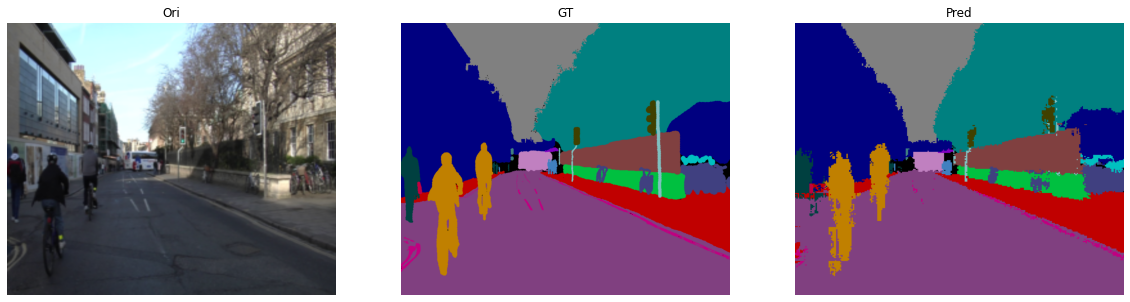

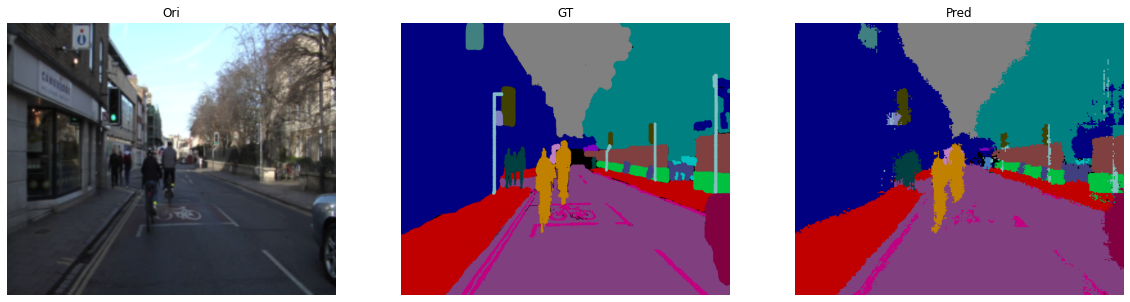

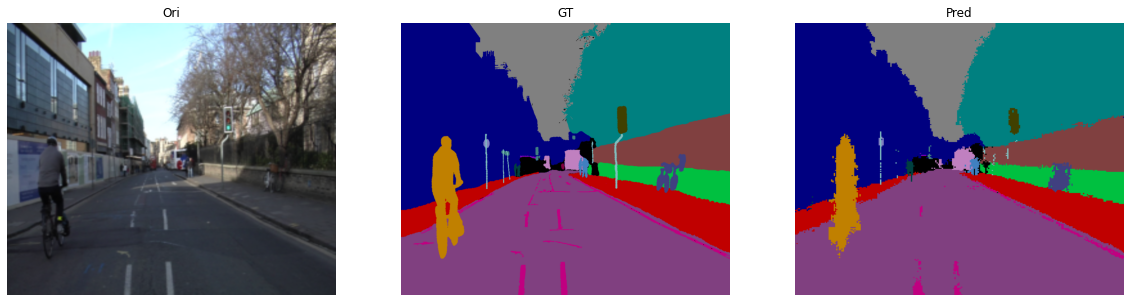

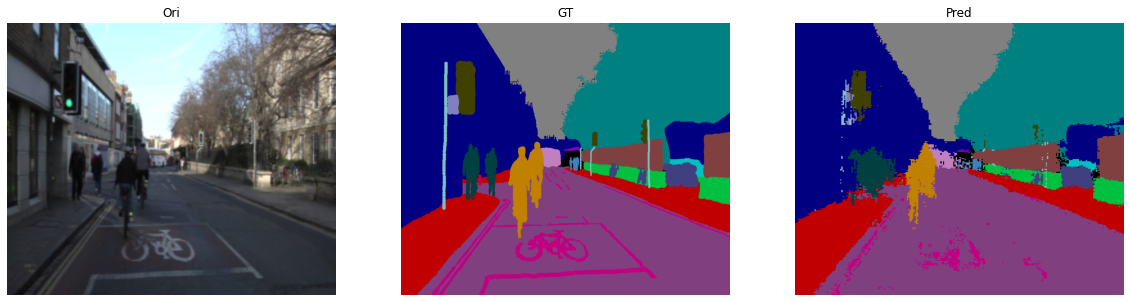

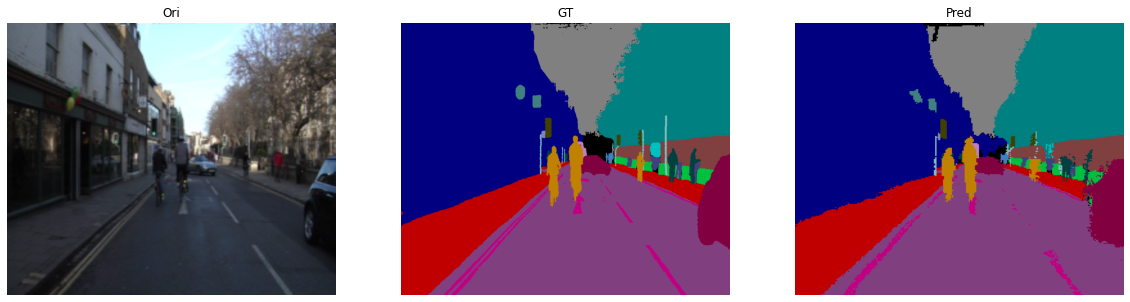

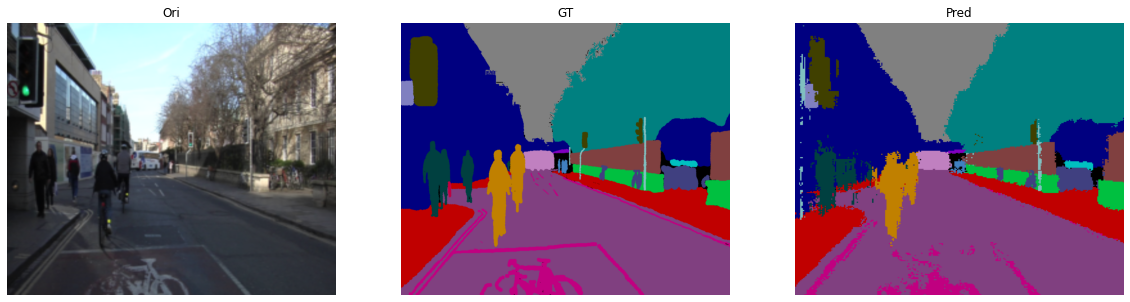

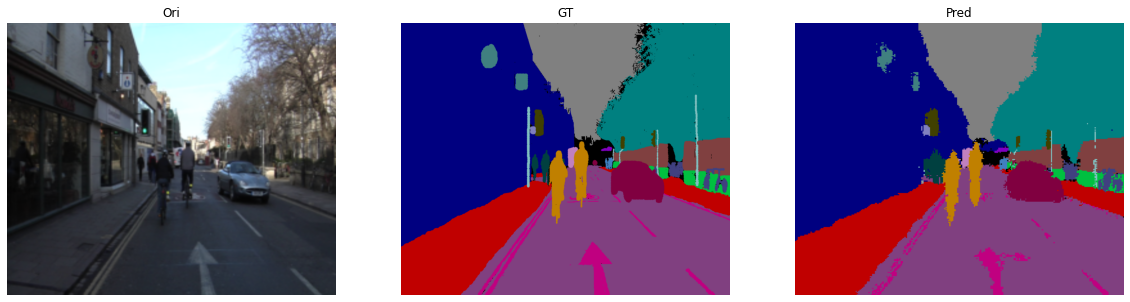

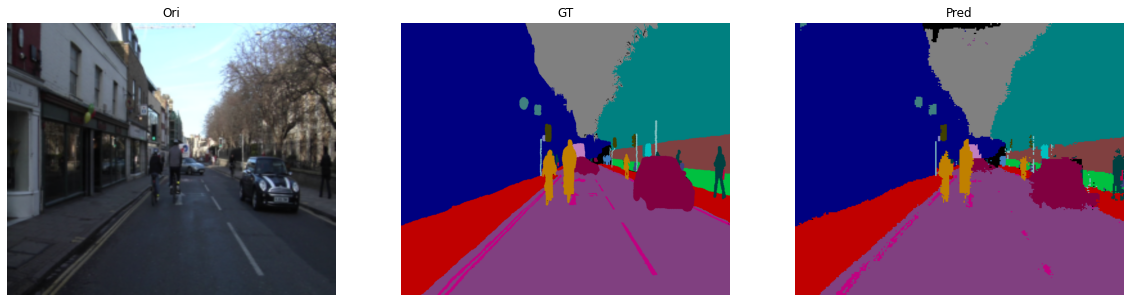

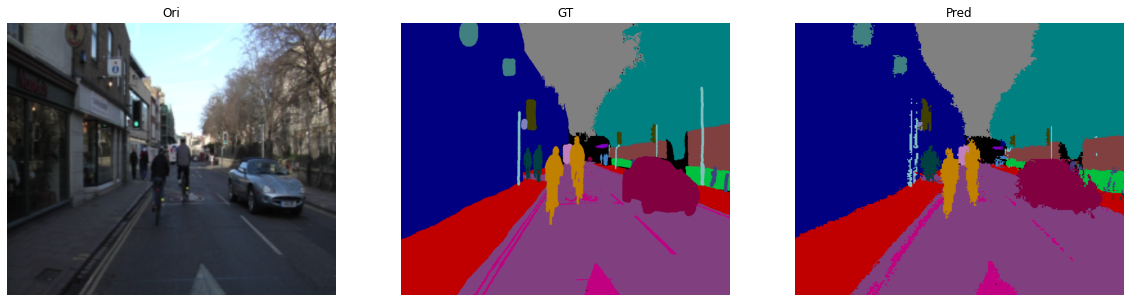

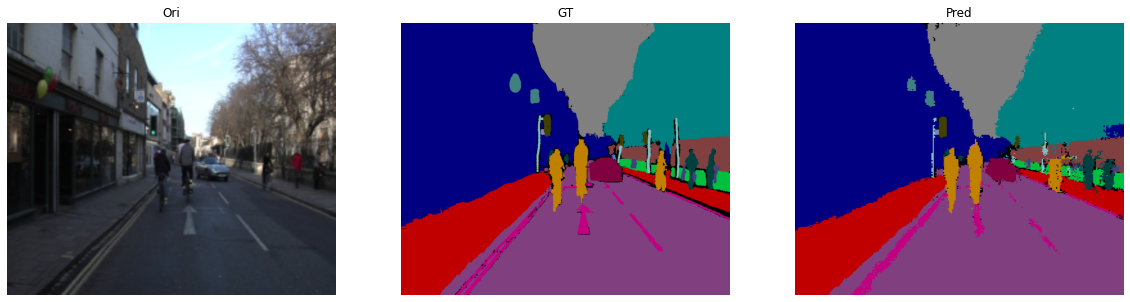

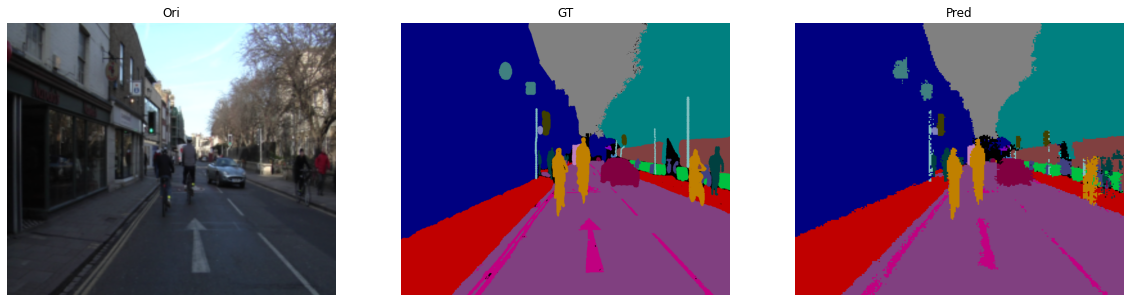

C:\Users\Moonbird\AppData\Local\Temp/ipykernel_15716/1675616011.py:43: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(stacked_iou, axis=0)


IOU:  0.5326080261236655
Pixel_Acc:  0.923397648358586
Inference_time(s/img):  0.01110539436340332

Model: FCN, Loss_Function: WCE, Augmentation: False
IOU:  0.28705722685087937
Pixel_Acc:  0.6555499000420876
Inference_time(s/img):  0.01161661148071289

Model: FCN, Loss_Function: Dice, Augmentation: False
IOU:  0.20013750940954947
Pixel_Acc:  0.8479527041245791
Inference_time(s/img):  0.010903072357177735

Model: Unet, Loss_Function: CE, Augmentation: False
IOU:  0.6613192646744472
Pixel_Acc:  0.9527815919612795
Inference_time(s/img):  0.005099701881408692

Model: Unet, Loss_Function: WCE, Augmentation: False
IOU:  0.5847910348843238
Pixel_Acc:  0.9168265993265994
Inference_time(s/img):  0.004603147506713867

Model: Unet, Loss_Function: Dice, Augmentation: False
IOU:  0.2910893012519901
Pixel_Acc:  0.9017066498316498
Inference_time(s/img):  0.004967117309570312

Model: deeplab, Loss_Function: CE, Augmentation: False
IOU:  0.6009846428433765
Pixel_Acc:  0.9427693602693602
Inference_time

In [33]:
model = ['', 'FCN', 'Unet', 'deeplab']
loss = ['', 'CE', 'WCE', 'Dice']

test_path = os.path.join('./test')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 1
num_classes = 32
test_samples, _= make_dataset(test_path, 0)
test_data = CAM101TestingData(test_samples) 
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=0)
for b in range(2):
    is_aug = b
    for i in range(1, 4):
        for j in range(1, 4):
            print(f'Model: {model[i]}, Loss_Function: {loss[j]}, Augmentation: {bool(is_aug)}' )
            test_iou, test_acc, total_time = test(model[i], test_dataloader, loss[j], bool(is_aug))
            print("IOU: ", np.nanmean(test_iou))
            print("Pixel_Acc: ", test_acc)
            print("Inference_time(s/img): ", total_time/10)
            print()